# Preprocessing: Force Coefficient Data

This notebook processes raw DES force coefficient data:
1. Discovers available cases
2. Loads and corrects force coefficients  
3. Computes mean coefficients
4. Extracts spectral descriptors (Strouhal, amplitude, Q)
5. Creates case-level HDF5 files
6. Exports summary.parquet for ML training
7. Generates data splits

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Robustly set project root and add to path
current_dir = Path.cwd()
if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
    sys.path.append(str(project_root))
else:
    raise FileNotFoundError("Could not find project root with 'src' directory")

print(f"Project root: {project_root}")

from src.data.preprocessing import (
    discover_cases,
    process_case,
    save_case_to_hdf5,
    SHAPE_PARAMS
)
from src.data.features import (
    extract_cl_spectral_features,
    create_nondimensional_features
)
from src.data.splits import (
    create_shape_holdout_split,
    create_aoa_interpolation_split,
    save_split,
    validate_split,
    print_split_summary
)

Project root: /Users/mingz/Projects/251120_PINN_Triangle_frequency_O


## 1. Discover Available Cases

In [2]:
# Path to raw DES data
RAW_DATA_PATH = Path('/Volumes/MHSSD/Projects/aeroelasticity/data')

# Discover cases (U_ref is automatically detected)
cases_df = discover_cases(RAW_DATA_PATH)

print(f"\nFound {len(cases_df)} cases:")
print("\nCases by shape variant:")
print(cases_df.groupby('shape_variant').agg({'aoa': ['count', 'min', 'max'], 'U_ref': 'first'}))

print("\nU_ref by shape variant:")
print(cases_df[['shape_variant', 'U_ref']].drop_duplicates())


Found 75 cases:

Cases by shape variant:
                   aoa          U_ref
                 count min  max first
shape_variant                        
baseline            15  55  125  21.5
baseline_lowU       15  55  125   5.0
baseline_mediumU    15  55  125  10.0
shorter             15  55  125  21.5
taller              15  55  125  21.5

U_ref by shape variant:
       shape_variant  U_ref
0           baseline   21.5
15     baseline_lowU    5.0
30  baseline_mediumU   10.0
45            taller   21.5
60           shorter   21.5


## 2. Process Cases

**U_ref is automatically detected based on folder names:**
- `baseline_lowU`: 5.0 m/s
- `baseline_mediumU`: 10.0 m/s  
- All others (baseline, taller, shorter): 21.5 m/s

In [3]:
# Process all cases
processed_cases = []
output_dir = project_root / 'data' / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Saving processed data to: {output_dir}")

for idx, row in tqdm(cases_df.iterrows(), total=len(cases_df), desc="Processing cases"):
    try:
        # Process case (U_ref is auto-detected from case_path)
        case_data = process_case(
            force_file_path=row['force_file'],
            shape_type=row['shape_type'],
            aoa=row['aoa'],
            case_path=row['path'],  # Used for auto U_ref detection
            settling_time=80.0,  # seconds
        )
        
        # Extract spectral features from Cl
        spectral_features = extract_cl_spectral_features(
            df=case_data['time_series'],
            D=case_data['D'],
            U=case_data['U_ref'],
            settling_time=80.0,
            fs=4000.0  # 4 kHz sampling
        )
        
        # Add spectral features to case data
        case_data.update(spectral_features)
        
        # Create non-dimensional features
        nd_features = create_nondimensional_features(case_data)
        case_data.update(nd_features)
        
        # Save to HDF5
        h5_filename = f"{row['shape_variant']}_{row['aoa']:03d}.h5"
        save_case_to_hdf5(case_data, output_dir / h5_filename)
        
        # Collect summary data
        summary = {
            'shape_type': case_data['shape_type'],
            'shape_variant': row['shape_variant'],
            'aoa': case_data['aoa'],
            'aoa_rad': case_data['aoa_rad'],
            'U_ref': case_data['U_ref'],
            'D': case_data['D'],
            'H': case_data['H'],
            'H_over_D': case_data['H_over_D'],
            'Re': case_data['Re'],
            'sin_aoa': case_data['sin_aoa'],
            'cos_aoa': case_data['cos_aoa'],
            'St_peak': case_data['St_peak'],
            'A_peak': case_data['A_peak'],
            'Q': case_data['Q'],
            'freq_peak': case_data['freq_peak'],
            'mean_Cd': case_data['mean_Cd'],
            'mean_Cl': case_data['mean_Cl'],
            'mean_Cm': case_data['mean_Cm'],
            'std_Cd': case_data['std_Cd'],
            'std_Cl': case_data['std_Cl'],
            'std_Cm': case_data['std_Cm'],
            'h5_file': h5_filename,
        }
        processed_cases.append(summary)
        
    except Exception as e:
        print(f"\nError processing {row['shape_variant']} AoA={row['aoa']}: {e}")
        continue

print(f"\nSuccessfully processed {len(processed_cases)} cases")

Saving processed data to: /Users/mingz/Projects/251120_PINN_Triangle_frequency_O/data/processed


Processing cases:  61%|██████▏   | 46/75 [00:09<00:06,  4.55it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  63%|██████▎   | 47/75 [00:10<00:06,  4.47it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  64%|██████▍   | 48/75 [00:10<00:06,  4.38it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  65%|██████▌   | 49/75 [00:10<00:06,  4.30it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  67%|██████▋   | 50/75 [00:10<00:05,  4.35it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  68%|██████▊   | 51/75 [00:11<00:05,  4.30it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  69%|██████▉   | 52/75 [00:11<00:05,  4.28it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  71%|███████   | 53/75 [00:11<00:05,  4.30it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  72%|███████▏  | 54/75 [00:11<00:04,  4.29it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  73%|███████▎  | 55/75 [00:11<00:04,  4.32it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  75%|███████▍  | 56/75 [00:12<00:04,  4.31it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  76%|███████▌  | 57/75 [00:12<00:04,  4.30it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  77%|███████▋  | 58/75 [00:12<00:03,  4.35it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  79%|███████▊  | 59/75 [00:12<00:03,  4.31it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  80%|████████  | 60/75 [00:13<00:03,  4.37it/s]

Applied lRef correction for taller: 1.500000m → 2.000000m


Processing cases:  81%|████████▏ | 61/75 [00:13<00:03,  4.31it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  83%|████████▎ | 62/75 [00:13<00:02,  4.37it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  84%|████████▍ | 63/75 [00:13<00:02,  4.29it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  85%|████████▌ | 64/75 [00:14<00:02,  4.29it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  87%|████████▋ | 65/75 [00:14<00:02,  4.22it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  88%|████████▊ | 66/75 [00:14<00:02,  4.20it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  89%|████████▉ | 67/75 [00:14<00:01,  4.24it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  91%|█████████ | 68/75 [00:14<00:01,  4.32it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  92%|█████████▏| 69/75 [00:15<00:01,  4.37it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  93%|█████████▎| 70/75 [00:15<00:01,  4.38it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  95%|█████████▍| 71/75 [00:15<00:00,  4.37it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  96%|█████████▌| 72/75 [00:15<00:00,  4.37it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  97%|█████████▋| 73/75 [00:16<00:00,  4.35it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases:  99%|█████████▊| 74/75 [00:16<00:00,  4.40it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m


Processing cases: 100%|██████████| 75/75 [00:16<00:00,  4.53it/s]

Applied lRef correction for shorter: 1.500000m → 1.000000m

Successfully processed 75 cases


## 3. Create Summary Table

In [4]:
summary_df = pd.DataFrame(processed_cases)

# Save to CSV (for easy viewing)
summary_csv_path = output_dir / 'summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"Saved summary to {summary_csv_path}")

# Save to Parquet (for efficient loading)
summary_parquet_path = output_dir / 'summary.parquet'
summary_df.to_parquet(summary_parquet_path, index=False)
print(f"Saved summary to {summary_parquet_path}")

# Display summary
print(f"\nSummary statistics:")
print(summary_df.describe())

# Show first few rows
summary_df.head()

Saved summary to /Users/mingz/Projects/251120_PINN_Triangle_frequency_O/data/processed/summary.csv
Saved summary to /Users/mingz/Projects/251120_PINN_Triangle_frequency_O/data/processed/summary.parquet

Summary statistics:
              aoa    aoa_rad      U_ref     D          H   H_over_D  \
count   75.000000  75.000000  75.000000  75.0  75.000000  75.000000   
mean    90.000000   1.570796  15.900000   3.0   1.500000   0.500000   
std     21.747942   0.379573   7.085863   0.0   0.318357   0.106119   
min     55.000000   0.959931   5.000000   3.0   1.000000   0.333333   
25%     70.000000   1.221730  10.000000   3.0   1.500000   0.500000   
50%     90.000000   1.570796  21.500000   3.0   1.500000   0.500000   
75%    110.000000   1.919862  21.500000   3.0   1.500000   0.500000   
max    125.000000   2.181662  21.500000   3.0   2.000000   0.666667   

                 Re    sin_aoa       cos_aoa    St_peak     A_peak          Q  \
count  7.500000e+01  75.000000  7.500000e+01  75.000000 

,shape_type,shape_variant,aoa,aoa_rad,U_ref,D,H,H_over_D,Re,sin_aoa,...,A_peak,Q,freq_peak,mean_Cd,mean_Cl,mean_Cm,std_Cd,std_Cl,std_Cm,h5_file
0,baseline,baseline,85,1.483530,21.5,3.0,1.5,0.5,4300000.0,0.996195,...,1.100668,0.0,2.441406,2.708742,0.333836,1.998115,0.230467,0.927275,0.439018,baseline_085.h5
1,baseline,baseline,75,1.308997,21.5,3.0,1.5,0.5,4300000.0,0.965926,...,0.332016,1.5,1.464844,3.145824,-1.191533,1.558708,0.265917,0.539439,0.734889,baseline_075.h5
2,baseline,baseline,70,1.221730,21.5,3.0,1.5,0.5,4300000.0,0.939693,...,0.362648,0.0,1.464844,3.485244,-1.663970,1.314990,0.277561,0.557943,0.779434,baseline_070.h5
3,baseline,baseline,65,1.134464,21.5,3.0,1.5,0.5,4300000.0,0.906308,...,0.391969,0.0,1.464844,3.775553,-2.117573,1.010781,0.313509,0.571409,0.812429,baseline_065.h5
4,baseline,baseline,60,1.047198,21.5,3.0,1.5,0.5,4300000.0,0.866025,...,0.339174,1.5,1.464844,3.804761,-2.645630,0.534278,0.321897,0.535475,0.807736,baseline_060.h5


## 4. Create Data Splits

In [5]:
splits_dir = project_root / 'data' / 'splits'
splits_dir.mkdir(parents=True, exist_ok=True)

# Create shape holdout splits (one for each base shape)
for shape in ['baseline', 'taller', 'shorter']:
    split = create_shape_holdout_split(
        summary_df,
        holdout_shape=shape,
        val_fraction=0.15,
        random_seed=42
    )
    
    validate_split(split, len(summary_df))
    print_split_summary(split, summary_df)
    
    save_split(split, splits_dir / f'shape_holdout_{shape}.json')

✓ Split validation passed: 26 train, 4 val, 45 test

Split type: shape_holdout

TRAIN (26 cases):
  Shapes: {'taller': 15, 'shorter': 11}
  AoA range: 55° to 125°
  Re range: 4.3e+06 to 4.3e+06

VAL (4 cases):
  Shapes: {'shorter': 4}
  AoA range: 75° to 115°
  Re range: 4.3e+06 to 4.3e+06

TEST (45 cases):
  Shapes: {'baseline': 45}
  AoA range: 55° to 125°
  Re range: 1.0e+06 to 4.3e+06
Saved split to /Users/mingz/Projects/251120_PINN_Triangle_frequency_O/data/splits/shape_holdout_baseline.json
✓ Split validation passed: 51 train, 9 val, 15 test

Split type: shape_holdout

TRAIN (51 cases):
  Shapes: {'baseline': 39, 'shorter': 12}
  AoA range: 55° to 125°
  Re range: 1.0e+06 to 4.3e+06

VAL (9 cases):
  Shapes: {'baseline': 6, 'shorter': 3}
  AoA range: 55° to 125°
  Re range: 2.0e+06 to 4.3e+06

TEST (15 cases):
  Shapes: {'taller': 15}
  AoA range: 55° to 125°
  Re range: 4.3e+06 to 4.3e+06
Saved split to /Users/mingz/Projects/251120_PINN_Triangle_frequency_O/data/splits/shape_hol

In [6]:
# Create AoA interpolation split
# Test on intermediate angles, train on others
all_aoas = sorted(summary_df['aoa'].unique())
test_aoas = all_aoas[1::3]  # Every 3rd angle starting from 2nd

print(f"All AoA values: {all_aoas}")
print(f"Test AoA values: {test_aoas}")

split = create_aoa_interpolation_split(
    summary_df,
    test_aoas=test_aoas,
    val_fraction=0.15,
    random_seed=42
)

validate_split(split, len(summary_df))
print_split_summary(split, summary_df)

save_split(split, splits_dir / 'aoa_interpolation.json')

All AoA values: [np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95), np.int64(100), np.int64(105), np.int64(110), np.int64(115), np.int64(120), np.int64(125)]
Test AoA values: [np.int64(60), np.int64(75), np.int64(90), np.int64(105), np.int64(120)]
✓ Split validation passed: 43 train, 7 val, 25 test

Split type: aoa_interpolation

TRAIN (43 cases):
  Shapes: {'baseline': 27, 'taller': 8, 'shorter': 8}
  AoA range: 55° to 125°
  Re range: 1.0e+06 to 4.3e+06

VAL (7 cases):
  Shapes: {'baseline': 3, 'taller': 2, 'shorter': 2}
  AoA range: 70° to 125°
  Re range: 1.0e+06 to 4.3e+06

TEST (25 cases):
  Shapes: {'baseline': 15, 'taller': 5, 'shorter': 5}
  AoA range: 60° to 120°
  Re range: 1.0e+06 to 4.3e+06
Saved split to /Users/mingz/Projects/251120_PINN_Triangle_frequency_O/data/splits/aoa_interpolation.json


## 5. Quick Visualization

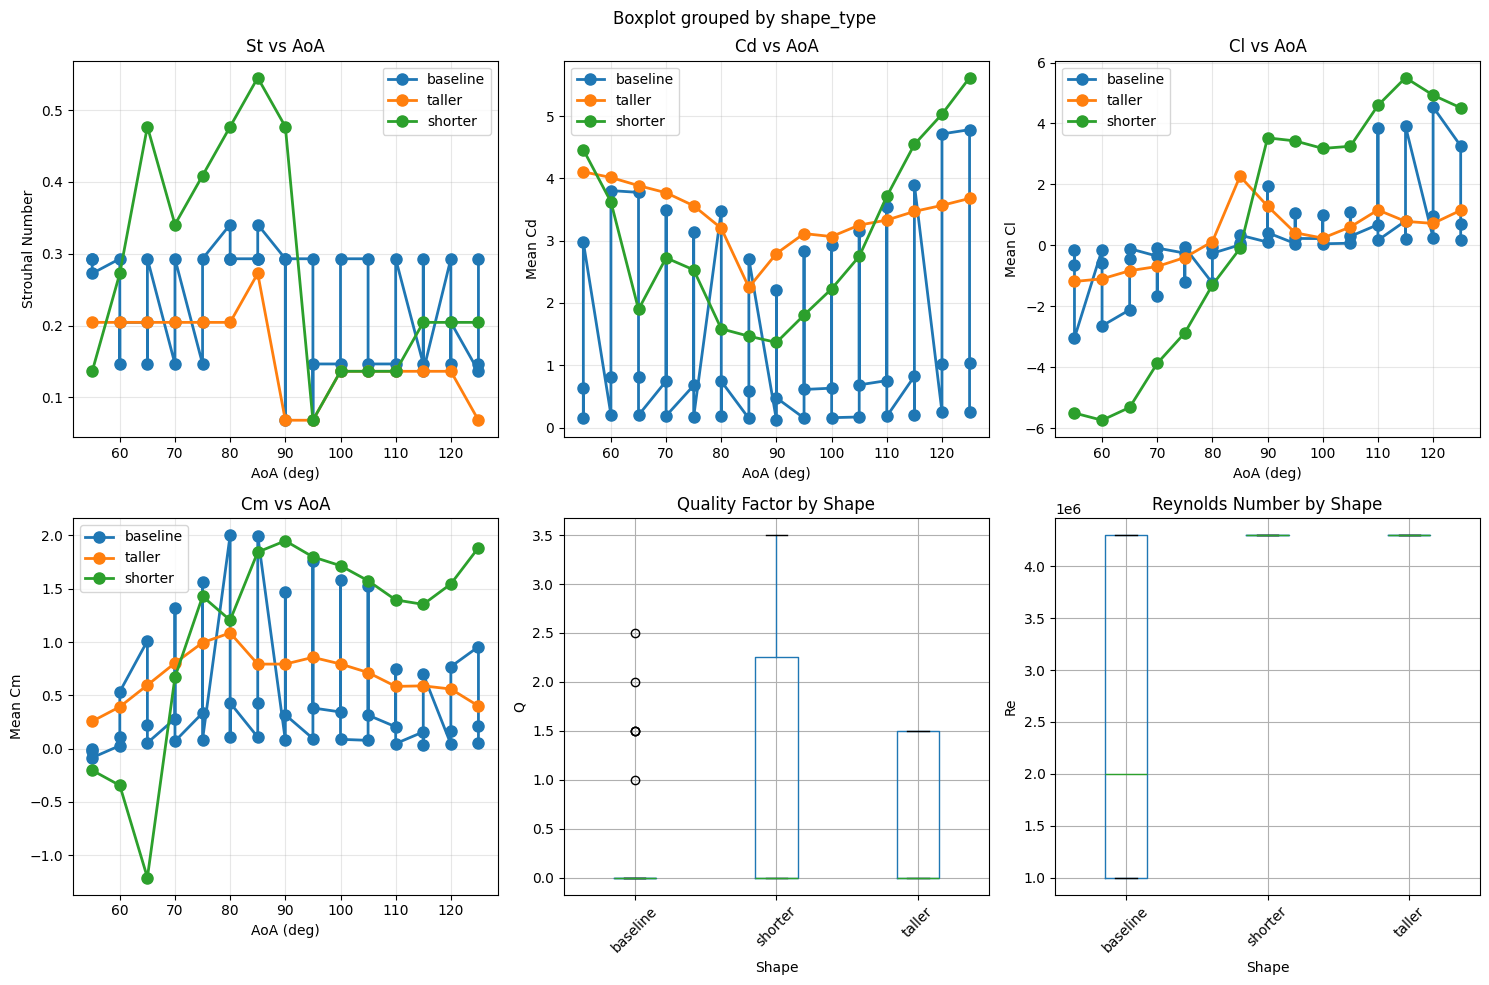


Preprocessing complete!


In [7]:
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# St vs AoA
ax = axes[0, 0]
for shape in summary_df['shape_type'].unique():
    data = summary_df[summary_df['shape_type'] == shape].sort_values('aoa')
    ax.plot(data['aoa'], data['St_peak'], 'o-', label=shape, markersize=8, linewidth=2)
ax.set_xlabel('AoA (deg)')
ax.set_ylabel('Strouhal Number')
ax.set_title('St vs AoA')
ax.legend()
ax.grid(True, alpha=0.3)

# Cd vs AoA
ax = axes[0, 1]
for shape in summary_df['shape_type'].unique():
    data = summary_df[summary_df['shape_type'] == shape].sort_values('aoa')
    ax.plot(data['aoa'], data['mean_Cd'], 'o-', label=shape, markersize=8, linewidth=2)
ax.set_xlabel('AoA (deg)')
ax.set_ylabel('Mean Cd')
ax.set_title('Cd vs AoA')
ax.legend()
ax.grid(True, alpha=0.3)

# Cl vs AoA
ax = axes[0, 2]
for shape in summary_df['shape_type'].unique():
    data = summary_df[summary_df['shape_type'] == shape].sort_values('aoa')
    ax.plot(data['aoa'], data['mean_Cl'], 'o-', label=shape, markersize=8, linewidth=2)
ax.set_xlabel('AoA (deg)')
ax.set_ylabel('Mean Cl')
ax.set_title('Cl vs AoA')
ax.legend()
ax.grid(True, alpha=0.3)

# Cm vs AoA
ax = axes[1, 0]
for shape in summary_df['shape_type'].unique():
    data = summary_df[summary_df['shape_type'] == shape].sort_values('aoa')
    ax.plot(data['aoa'], data['mean_Cm'], 'o-', label=shape, markersize=8, linewidth=2)
ax.set_xlabel('AoA (deg)')
ax.set_ylabel('Mean Cm')
ax.set_title('Cm vs AoA')
ax.legend()
ax.grid(True, alpha=0.3)

# Q factor distribution
ax = axes[1, 1]
summary_df.boxplot(column='Q', by='shape_type', ax=ax)
ax.set_title('Quality Factor by Shape')
ax.set_xlabel('Shape')
ax.set_ylabel('Q')
plt.sca(ax)
plt.xticks(rotation=45)

# Re distribution
ax = axes[1, 2]
summary_df.boxplot(column='Re', by='shape_type', ax=ax)
ax.set_title('Reynolds Number by Shape')
ax.set_xlabel('Shape')
ax.set_ylabel('Re')
plt.sca(ax)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(project_root / 'reports/figures/preprocessing_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPreprocessing complete!")